<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/GDF_OPS_applications/blob/main/gasandschools.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Moving Gas Stations away from Schools in Boston, MA

# Getting ready

## Installations needed

In [ ]:
# !pip install osmnx pysal

## Data needed

### Official data preprocessing

We need the boston map. As we are going to analize schools and gas stations we must omit the water bodies. A good option is:


*   https://www.mass.gov/info-details/massgis-data-municipalities

You will select the shapefile for Boston from there. The file returned will be a zip, which I have saved on GitHub from where I read it:



In [67]:
import geopandas as gpd

filez="https://github.com/DACSS-Spatial/data_forSpatial/raw/refs/heads/main/BOSTON/GISDATA.TOWNSSURVEY_POLYM.zip"
boston=gpd.read_file(filez)
boston.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   town        1 non-null      object  
 1   town_id     1 non-null      int32   
 2   type        1 non-null      object  
 3   county      1 non-null      object  
 4   fips_stco   1 non-null      int32   
 5   fourcolor   1 non-null      int32   
 6   pop1960     1 non-null      int32   
 7   pop1970     1 non-null      int32   
 8   pop1980     1 non-null      int32   
 9   pop1990     1 non-null      int32   
 10  pop2000     1 non-null      int32   
 11  pop2010     1 non-null      int32   
 12  pop2020     1 non-null      int32   
 13  popch10_20  1 non-null      int32   
 14  area_acres  1 non-null      float64 
 15  area_sqmi   1 non-null      float64 
 16  geometry    1 non-null      geometry
dtypes: float64(2), geometry(1), int32(11), object(3)
memory usage: 224.0+ bytes


As you see, it is just one geometry:

In [68]:
boston

,town,town_id,type,county,fips_stco,fourcolor,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020,popch10_20,area_acres,area_sqmi,geometry
0,BOSTON,35,C,SUFFOLK,25025,1,697197,641071,562994,574283,588957,617594,675647,58053,32104.34973,50.15997,"MULTIPOLYGON (((235056.153 904531.255, 235060...."


The map we have has come projected:

In [69]:
boston.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meter)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Crowdsourced data pre processing

Now we need the schools and gas stations. Let's become familiar with OpenStreet Maps [API for Python](https://osmnx.readthedocs.io/en/stable/), which for our case would be very useful.

You can get the gas stations from Boston like this:


In [73]:
# Get gas stations in Boston
import osmnx as ox

stations = ox.features_from_place("Boston, Massachusetts, USA",
                                tags={'amenity': 'fuel'})

Notice we are getting several gas stations, already as a GDF:

In [74]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 55 entries, ('node', np.int64(1547613299)) to ('way', np.int64(997511426))
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              55 non-null     geometry
 1   amenity               55 non-null     object  
 2   addr:city             21 non-null     object  
 3   addr:housenumber      26 non-null     object  
 4   addr:postcode         23 non-null     object  
 5   addr:state            20 non-null     object  
 6   addr:street           26 non-null     object  
 7   brand                 36 non-null     object  
 8   brand:wikidata        36 non-null     object  
 9   name                  45 non-null     object  
 10  opening_hours         7 non-null      object  
 11  compressed_air        9 non-null      object  
 12  source                4 non-null      object  
 13  ref                   7 non-null      object  
 1

OSM gave you stations unprojected:

In [75]:
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the multi-index:

In [76]:
stations

geometry  \
element  id                                                               
node     1547613299                          POINT (-71.11921 42.27983)   
         1915267811                          POINT (-71.12623 42.35823)   
         1975943661                          POINT (-71.05651 42.32059)   
         2086266695                          POINT (-71.15482 42.29539)   
         2108017693                          POINT (-71.15664 42.26192)   
         2108018346                          POINT (-71.16118 42.25828)   
         2108019392                          POINT (-71.15166 42.28766)   
         2299726166                           POINT (-71.11332 42.3174)   
         4119910813                          POINT (-71.11833 42.29594)   
         4456008435                          POINT (-71.03919 42.37176)   
         4456091896                          POINT (-71.02777 42.37965)   
         4456091915                          POINT (-71.00924 42.38557)   
         5012538664                          POINT (-71.04636 42.28384)   
         7049179057                          POINT (-71.13113 42.28346)   
         7711828654                          POINT (-71.09536 42.34499)   
         7779156553                          POINT (-71.03967 42.38287)   
         7801604967                          POINT (-71.06318 42.37186)   
         8911740730                          POINT (-71.12258 42.24965)   
         9155798164                          POINT (-71.11235 42.33173)   
         9301640141                          POINT (-71.12988 42.35254)   
         9307561244                             POINT (-71.08 42.38247)   
         9826872460                          POINT (-71.13487 42.35426)   
         11512786470                         POINT (-71.11478 42.27676)   
         12636225024                         POINT (-71.15399 42.34196)   
         12850165667                         POINT (-71.14183 42.34454)   
         13205043192                          POINT (-71.07321 42.2714)   
         13205071184                          POINT (-71.1061 42.27145)   
relation 13500843     POLYGON ((-71.02803 42.36628, -71.02801 42.366...   
way      29520631     POLYGON ((-71.02751 42.37897, -71.02755 42.379...   
         29613466     POLYGON ((-71.0565 42.3211, -71.05662 42.32109...   
         29622378     POLYGON ((-71.05527 42.33449, -71.05539 42.334...   
         29648812     POLYGON ((-71.07091 42.33124, -71.07092 42.331...   
         29650844     POLYGON ((-71.08125 42.33912, -71.08128 42.339...   
         29677198     POLYGON ((-71.12761 42.23623, -71.1277 42.2362...   
         29680301     POLYGON ((-71.13046 42.36279, -71.13047 42.362...   
         29778889     POLYGON ((-71.14953 42.35589, -71.1497 42.3559...   
         29779289     POLYGON ((-71.16721 42.35018, -71.16746 42.350...   
         29804770     POLYGON ((-71.05959 42.31409, -71.05971 42.314...   
         29805421     POLYGON ((-71.07033 42.33183, -71.07046 42.331...   
         29806343     POLYGON ((-71.09524 42.3456, -71.09529 42.3456...   
         29829809     POLYGON ((-71.11445 42.31527, -71.11447 42.315...   
         29831768     POLYGON ((-71.04201 42.28608, -71.04206 42.286...   
         29833313     POLYGON ((-71.04847 42.29561, -71.04855 42.295...   
         29887927     POLYGON ((-71.11912 42.27979, -71.11931 42.279...   
         29934128     POLYGON ((-71.1142 42.31577, -71.1143 42.3158,...   
         29934166     POLYGON ((-71.10606 42.30727, -71.10635 42.307...   
         29941823     POLYGON ((-71.10334 42.33343, -71.10368 42.333...   
         29946760     POLYGON ((-71.05551 42.34139, -71.05548 42.341...   
         212124454    POLYGON ((-71.06475 42.32535, -71.06441 42.325...   
         212129122    POLYGON ((-71.11089 42.32082, -71.11083 42.320...   
         350480325    POLYGON ((-71.13054 42.36304, -71.13037 42.363...   
         405514198    POLYGON ((-71.08174 42.34024, -71.08186 42.340...   
         6444

In the multi index you see **nodes**, **relations**, and **ways**:

In [77]:
stations.index

MultiIndex([(    'node',  1547613299),
            (    'node',  1915267811),
            (    'node',  1975943661),
            (    'node',  2086266695),
            (    'node',  2108017693),
            (    'node',  2108018346),
            (    'node',  2108019392),
            (    'node',  2299726166),
            (    'node',  4119910813),
            (    'node',  4456008435),
            (    'node',  4456091896),
            (    'node',  4456091915),
            (    'node',  5012538664),
            (    'node',  7049179057),
            (    'node',  7711828654),
            (    'node',  7779156553),
            (    'node',  7801604967),
            (    'node',  8911740730),
            (    'node',  9155798164),
            (    'node',  9301640141),
            (    'node',  9307561244),
            (    'node',  9826872460),
            (    'node', 11512786470),
            (    'node', 12636225024),
            (    'node', 12850165667),
            (    'node', 

Some formatting may be needed at this stage:

- This will put current indexes back into the data, and numbers will appear:

In [78]:
stations.reset_index(drop=False,inplace=True)
stations.head()

,element,id,geometry,amenity,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,brand,...,building,fuel:diesel,fuel:gasoline,layer,opening_hours:signed,operator,source:geometry,building:levels,fuel:octane_95,type
0,node,1547613299,POINT (-71.11921 42.27983),fuel,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,1915267811,POINT (-71.12623 42.35823),fuel,Allston,219,02134,MA,Cambridge Street,Shell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,1975943661,POINT (-71.05651 42.32059),fuel,Dorchester,888,02125,MA,Dorchester Avenue,Gulf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,2086266695,POINT (-71.15482 42.29539),fuel,NaN,NaN,NaN,NaN,NaN,Shell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,2108017693,POINT (-71.15664 42.26192),fuel,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Keep some columns:

In [79]:
colsToKeep=['element','name','geometry']
fuelBoston=stations[colsToKeep].copy()

- Reproject the data:

In [80]:
Boston_crs = "EPSG:26986"

fuelBoston = fuelBoston.to_crs(Boston_crs)

- Review:

In [81]:
fuelBoston.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   element   55 non-null     object  
 1   name      45 non-null     object  
 2   geometry  55 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.4+ KB


- From above, columns **name** of the gas station has missing values. We should rename those missing values:

In [82]:
fuelBoston.fillna({'name':'Unknown'},inplace=True)

- We usually use the names as row index. But row index should not have duplicates. Since several 'names' are the same (_Unknown_), we have to create new names:

In [83]:
fuelBoston.index.astype(str)+"_"+fuelBoston.name

0                0_Unknown
1                  1_Shell
2     2_Columbia Road Gulf
3                  3_Shell
4                4_Unknown
5               5_Speedway
6               6_Speedway
7                 7_JP Oil
8           8_Emporium Gas
9                  9_Shell
10                10_Mobil
11              11_Unknown
12                 12_Gulf
13              13_Unknown
14               14_Sunoco
15                15_Mobil
16                16_Shell
17                   17_BP
18                18_Citgo
19             19_Speedway
20             20_Speedway
21               21_Irving
22          22_Stop & Shop
23     23_Cumberland Farms
24                24_Mobil
25               25_Sunoco
26               26_Sunoco
27       27_Shell - Nouria
28                   28_BP
29             29_Speedway
30             30_Speedway
31               31_Sunoco
32                 32_Gulf
33                33_Mobil
34                 34_Gulf
35                 35_Gulf
36    36_Oak Square Sunoco
3

Then,

In [84]:
fuelBoston['newname']=fuelBoston.index.astype(str)+"_"+fuelBoston.name
fuelBoston.set_index('newname',inplace=True)
fuelBoston.drop(columns=['name'],inplace=True)
fuelBoston.head()

,element,geometry
newname,,
0_Unknown,node,POINT (231409.205 892220.97)
1_Shell,node,POINT (230791.53 900926.709)
2_Columbia Road Gulf,node,POINT (236556.832 896773.514)
3_Shell,node,POINT (228464.872 893936.856)
4_Unknown,node,POINT (228329.637 890218.87)


See that **nodes** are points, **ways** are lines or simple shapes built from points, and **relations** are conceptual containers that group any of the other elements to represent complex features.

Let me compare with the geometries available:


In [85]:
import pandas as pd

pd.crosstab(fuelBoston.element,fuelBoston.geometry.geom_type, margins=True)


col_0,Point,Polygon,All
element,,,
node,27,0,27
relation,0,1,1
way,0,27,27
All,27,28,55


This is the 'relation' we have:

In [86]:
#original data
stations[stations.element=='relation']

,element,id,geometry,amenity,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,brand,...,building,fuel:diesel,fuel:gasoline,layer,opening_hours:signed,operator,source:geometry,building:levels,fuel:octane_95,type
27,relation,13500843,"POLYGON ((-71.02803 42.36628, -71.02801 42.366...",fuel,NaN,45,02128,NaN,Transportation Way,Shell,...,roof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multipolygon


<Axes: >

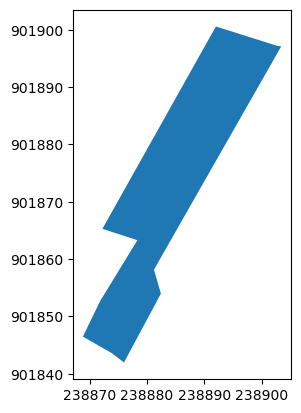

In [87]:
fuelBoston[fuelBoston.element=='relation'].plot()

Let me get the schools:

In [88]:
# Get schools in Boston
schools = ox.features_from_place("Boston, Massachusetts, USA",
                                tags={'amenity': 'school'})
schools.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 272 entries, ('node', np.int64(257493925)) to ('way', np.int64(1417025273))
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 272 non-null    geometry
 1   addr:city                185 non-null    object  
 2   addr:housenumber         197 non-null    object  
 3   addr:postcode            188 non-null    object  
 4   addr:state               166 non-null    object  
 5   addr:street              198 non-null    object  
 6   amenity                  272 non-null    object  
 7   attribution              116 non-null    object  
 8   gnis:feature_id          128 non-null    object  
 9   jurisdiction             1 non-null      object  
 10  name                     265 non-null    object  
 11  old_name                 12 non-null     object  
 12  source_url               27 non-null     object  
 13  gra

Let's reformat this as we did before:

In [89]:
schools.reset_index(inplace=True)
schoolBoston=schools[['element','name','geometry']].copy()
schoolBoston.fillna({'name':'Unknown'},inplace=True)
schoolBoston['newname']=schoolBoston.index.astype(str)+"_"+schoolBoston.name
schoolBoston.set_index('newname',inplace=True)
schoolBoston.drop(columns=['name'],inplace=True)
schoolBoston = schoolBoston.to_crs(Boston_crs)
schoolBoston.head()


,element,geometry
newname,,
0_Boston Police Academy,node,POINT (231587.542 888708.322)
1_Urban Science Academy,node,POINT (226876.32 892442.908)
2_Boston Middle School Academy,node,POINT (234181.887 894623.399)
3_Ralph Waldo Emerson School,node,POINT (235209.779 897088.628)
4_John Paul II Polish School,node,POINT (236451.673 897587.454)


See element vs geo:

In [90]:
pd.crosstab(schoolBoston.element,schoolBoston.geometry.geom_type, margins=True)

col_0,MultiPolygon,Point,Polygon,All
element,,,,
node,0,113,0,113
relation,1,0,5,6
way,0,0,153,153
All,1,113,158,272


In [91]:
#original data
schools[(schools.element=='relation') & (schools.geometry.geom_type=='MultiPolygon')]

,element,id,geometry,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,attribution,...,twitter,max_age,min_age,official_name,name:etymology:wikidata,mascot,note,isced:level,wikipedia:en,office
116,relation,3844332,"MULTIPOLYGON (((-71.16686 42.27773, -71.16687 ...",West Roxbury,235,02132,NaN,Baker Street,school,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

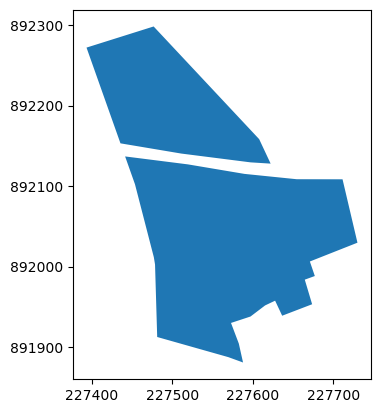

In [92]:
schoolBoston[(schoolBoston.element=='relation') & (schoolBoston.geometry.geom_type=='MultiPolygon')].plot()

In [93]:
base=boston.explore(tiles='cartodbpositron',color='lightblue')
schoolBoston.explore(m=base,color='k')
fuelBoston.explore(m=base,color='red')

# Explore proximity:


Let's compute a couple of distance matrices.

- The distance among fuel stations

In [94]:
D_Matrix_fuel_fuel=fuelBoston.geometry.apply\
(lambda station: fuelBoston.geometry.distance(station))

D_Matrix_fuel_fuel

newname,0_Unknown,1_Shell,2_Columbia Road Gulf,3_Shell,4_Unknown,5_Speedway,6_Speedway,7_JP Oil,8_Emporium Gas,9_Shell,...,45_Stan Hatoff's,46_Unknown,47_Southie Gas,48_Stop & Shop Gas,49_Unknown,50_Allston Gulf,51_Shell,52_Speedway,53_Roger's Services,54_Unknown
newname,,,,,,,,,,,,,,,,,,,,,
0_Unknown,0.000000,8727.624383,6871.952298,3407.837938,3673.165372,4209.712154,2813.964173,4201.365595,1790.404515,12155.739962,...,3234.495836,6095.242575,8620.620270,6760.384459,4602.264652,9268.657342,7386.485428,5883.133123,4860.331859,3884.455796
1_Shell,8727.624383,0.000000,7105.472646,7366.911850,10987.208647,11470.088910,8114.564055,4658.243433,6950.074505,7326.070600,...,5867.405363,3305.372464,6111.383061,6245.483625,4335.437151,616.085382,4161.170067,10476.799257,13464.647569,7763.762976
2_Columbia Road Gulf,6871.952298,7105.472646,0.000000,8574.756321,10519.035543,11064.397417,8655.942529,4696.391662,5785.564850,5859.694999,...,4331.598353,4113.489962,2305.082433,842.480604,4470.888788,7684.987331,3013.288615,4137.188866,11158.757928,9232.804703
3_Shell,3407.837938,7366.911850,8574.756321,0.000000,3720.444951,4155.568688,898.002993,4205.034626,3009.853106,12757.986963,...,4214.095164,5977.659946,9649.672607,8137.399622,4593.183084,7756.624042,7816.711177,8895.324825,6750.299648,658.507965
4_Unknown,3673.165372,10987.208647,10519.035543,3720.444951,0.000000,551.674425,2887.510892,7122.877723,4925.464710,15575.071746,...,6537.960311,9075.109742,12142.358940,10345.864017,7552.207045,11415.891646,10668.029754,9280.123532,3439.078579,3554.262419
5_Speedway,4209.712154,11470.088910,11064.397417,4155.568688,551.674425,0.000000,3356.249306,7662.016312,5476.509621,16125.184185,...,7088.725747,9611.237999,12694.008878,10896.053762,8091.038429,11887.740132,11215.288798,9752.331375,3381.699322,3926.944945
6_Speedway,2813.964173,8114.564055,8655.942529,898.002993,2887.510892,3356.249306,0.000000,4572.512317,2898.499218,13160.329148,...,4333.507414,6451.824616,9921.847613,8299.281817,4987.120000,8532.628063,8205.612961,8552.623751,5852.337979,1113.725238
7_JP Oil,4201.365595,4658.243433,4696.391662,4205.034626,7122.877723,7662.016312,4572.512317,0.000000,2419.748129,8588.937416,...,1241.998185,1960.893741,5459.022652,4100.235410,429.647109,5241.060168,3634.318645,6544.428046,9050.593963,4833.315836
8_Emporium Gas,1790.404515,6950.074505,5785.564850,3009.853106,4925.464710,5476.509621,2898.499218,2419.748129,0.000000,10652.080578,...,1613.378546,4343.655419,7231.798174,5494.062792,2829.639930,7499.948706,5771.354957,5946.473052,6630.854709,3648.146781


From here, we can compute the minimal distance among those gas stations:

In [95]:
D_Matrix_fuel_fuel.replace(0,None,inplace=True) # avoid the zero
D_Matrix_fuel_fuel.min(axis=1).sort_values().head(10)

newname
40_Gibbs Gas Station    48.487191
44_JP Gas               48.487191
29_Speedway             55.729518
2_Columbia Road Gulf    55.729518
31_Sunoco               66.650839
38_Unknown              66.650839
14_Sunoco               67.991699
39_Shell                67.991699
10_Mobil                69.527035
28_BP                   69.527035
dtype: object

- The distance among gas stations and schools:

In [96]:
D_Matrix_fuel_school=fuelBoston.geometry.apply\
(lambda station: schoolBoston.geometry.distance(station))

D_Matrix_fuel_school

newname,0_Boston Police Academy,1_Urban Science Academy,2_Boston Middle School Academy,3_Ralph Waldo Emerson School,4_John Paul II Polish School,5_Academy Of the Pacific Rim Charter Public School,6_Smith Leadership Academy Charter Public School,7_The Learning Project Elementary School,8_Lyndon,9_Eliot Elementary,...,262_Maurice J Tobin School,263_William Ellery Channing,264_Emily A Fifield School,265_Sarah Greenwood School,266_Joyce Kilmer School,267_Robert Gould Shaw Middle School,268_Frank W Thompson Middle School,269_Josiah Quincy Elementary School,270_Josiah Quincy Upper School,271_Italian Home for Children School
newname,,,,,,,,,,,,,,,,,,,,,
0_Unknown,3517.172373,4538.314533,3668.709777,6175.633927,7363.805994,3955.280914,5531.851825,8892.716105,3078.082221,11011.884118,...,6094.027891,3311.861500,3877.485852,3696.466905,3648.966085,3204.880248,3107.703357,8744.745535,8763.768694,2519.578877
1_Shell,12244.290100,9343.647624,7157.251605,5852.503222,6571.745828,12526.745937,8427.175998,4082.135425,7593.700123,6065.516344,...,3577.824538,11821.405873,9043.357522,7751.590351,10007.607833,8728.125278,9298.057232,5126.352377,5244.669476,6028.525154
2_Columbia Road Gulf,9473.181799,10605.020433,3203.648108,1383.419611,820.705094,10411.205910,2152.076759,4033.072522,8484.410901,5060.790603,...,3681.523118,9914.982628,3946.474058,3206.964180,10249.275203,9342.070973,4752.045981,3060.289866,3001.370974,6018.628205
3_Shell,6090.044288,2180.682657,5758.089941,7444.959838,8781.563134,5845.185924,7955.167693,9097.280039,368.378525,11471.081097,...,6180.145729,5140.207328,6796.810108,6117.847196,2645.098933,1366.297789,6237.546105,9379.137516,9436.950650,2315.987018
4_Unknown,3591.058820,2656.779444,7324.527882,9722.650156,10966.471948,2720.954364,9187.416199,12106.466319,3432.549911,14365.388885,...,9175.679742,2209.520760,7420.389293,7367.528360,1164.308095,2283.368252,6557.039305,12135.911449,12169.615827,5097.389773
5_Speedway,3795.183476,2843.577257,7867.642325,10273.832679,11515.960465,2784.007788,9711.387849,12650.106349,3888.425893,14913.672863,...,9716.552271,2377.773585,7921.808041,7899.815126,1466.066277,2688.826633,7049.037738,12685.902982,12719.957550,5635.160194
6_Speedway,5222.069546,1958.824895,5667.363486,7620.966318,8942.451556,4947.709018,7815.937994,9556.758148,558.089978,11897.024151,...,6612.252164,4243.943678,6472.132841,5949.102681,1939.012041,729.211464,5821.401338,9743.653141,9792.926447,2552.817236
7_JP Oil,7693.440150,6373.595359,2909.009606,3405.277505,4728.536028,8131.470068,4848.386353,5002.611327,4228.078505,7325.295482,...,2057.725566,7457.504144,4731.039491,3506.146738,6454.917222,5301.682850,4782.993855,5183.102452,5237.459061,1899.450800
8_Emporium Gas,5303.105183,4857.317730,2776.611052,4840.864788,6129.893860,5712.458287,4954.791044,7244.811933,2824.351629,9454.617256,...,4373.723192,5042.700192,3853.665647,3108.466172,4488.656268,3563.095519,3435.568293,7214.053460,7245.923486,932.157757


# Decision 1: Find the stations that should go away



Now, we could compute the minimal distance from a gas station to a school, and sort the stations by that value:

In [97]:
D_Matrix_fuel_school.min(axis=1).sort_values().head(10)

newname
28_BP                    16.344538
37_US Gas                16.817808
9_Shell                  47.383312
7_JP Oil                 82.297014
10_Mobil                 91.365677
2_Columbia Road Gulf     96.766745
29_Speedway              98.044988
42_Citgo                100.187359
51_Shell                171.630269
43_Unknown              176.522893
dtype: float64

By the previous exploration, we may decide that no station should at 100 or less from a school:

In [98]:
mindDist=100

# Decision 2: Secure perimeter of every school

Let's create the safe area around the school. This requires **buffer**:

In [99]:
schoolBoston_buffered=schoolBoston.buffer(mindDist)
schoolBoston_buffered

newname
0_Boston Police Academy                 POLYGON ((231687.542 888708.322, 231687.061 88...
1_Urban Science Academy                 POLYGON ((226976.32 892442.908, 226975.839 892...
2_Boston Middle School Academy          POLYGON ((234281.887 894623.399, 234281.406 89...
3_Ralph Waldo Emerson School            POLYGON ((235309.779 897088.628, 235309.297 89...
4_John Paul II Polish School            POLYGON ((236551.673 897587.454, 236551.191 89...
                                                              ...                        
267_Robert Gould Shaw Middle School     POLYGON ((228232.321 892671.365, 228247.737 89...
268_Frank W Thompson Middle School      POLYGON ((234473.715 892497.81, 234510.338 892...
269_Josiah Quincy Elementary School     POLYGON ((235891.494 899955.223, 235894.694 89...
270_Josiah Quincy Upper School          POLYGON ((235930.783 899885.411, 235974.218 89...
271_Italian Home for Children School    POLYGON ((230557.526 894717.821, 230549.825 89...
Le

In [100]:
#remember we have
type(schoolBoston_buffered)

geopandas.geoseries.GeoSeries

Turning GS into GDF:

In [101]:
secured_schoolBoston=gpd.GeoDataFrame(geometry=schoolBoston_buffered)
secured_schoolBoston

,geometry
newname,
0_Boston Police Academy,"POLYGON ((231687.542 888708.322, 231687.061 88..."
1_Urban Science Academy,"POLYGON ((226976.32 892442.908, 226975.839 892..."
2_Boston Middle School Academy,"POLYGON ((234281.887 894623.399, 234281.406 89..."
3_Ralph Waldo Emerson School,"POLYGON ((235309.779 897088.628, 235309.297 89..."
4_John Paul II Polish School,"POLYGON ((236551.673 897587.454, 236551.191 89..."
...,...
267_Robert Gould Shaw Middle School,"POLYGON ((228232.321 892671.365, 228247.737 89..."
268_Frank W Thompson Middle School,"POLYGON ((234473.715 892497.81, 234510.338 892..."
269_Josiah Quincy Elementary School,"POLYGON ((235891.494 899955.223, 235894.694 89..."


Buffers created polygons:

In [102]:
secured_schoolBoston.geometry.geom_type.value_counts()

Polygon    272
Name: count, dtype: int64

# Decision 3: Standardized Gas stations geometries

Not all gas stations are points:

In [103]:
fuelBoston.geometry.geom_type.value_counts()

Polygon    28
Point      27
Name: count, dtype: int64

The point is a simple representation. Then let's make a buffer of 10 meters for every station to make sure the station is selected even if we just had one of its points.

In [104]:
fuelBoston_allPoly=fuelBoston.copy()
fuelBoston_allPoly['geometry'] = [
    station.buffer(10) if station.geom_type == 'Point' else station
    for station in fuelBoston.geometry
]

In [105]:
# rechecking
fuelBoston_allPoly.geometry.geom_type.value_counts()

Polygon    55
Name: count, dtype: int64

# Decision 4: Overlay or SJoin to determine gas stations in trouble

This is great moment to test our understanding of these ops:

- do you want to move the points from the gas stations that are close to the schools?

In [106]:
fuelBoston_allPoly.overlay(secured_schoolBoston,how='intersection',keep_geom_type=False)

,element,geometry
0,node,"POLYGON ((236558.783 896763.706, 236557.812 89..."
1,node,"POLYGON ((231885.561 896395.387, 231885.417 89..."
2,node,"POLYGON ((237964.427 902463.107, 237964.283 90..."
3,node,"POLYGON ((237964.427 902463.107, 237964.283 90..."
4,node,"POLYGON ((238900.171 903345.039, 238900.027 90..."
5,way,"POLYGON ((238908.242 903276.883, 238915.107 90..."
6,way,"POLYGON ((236547.608 896829.127, 236547.577 89..."
7,way,"POLYGON ((236296.682 896059.083, 236302.183 89..."


- do you want to move the gas stations that are close to the schools?

In [107]:
fuelBoston_allPoly.sjoin(secured_schoolBoston,how='inner',predicate='intersects')

,element,geometry,newname_right
newname_left,,,
2_Columbia Road Gulf,node,"POLYGON ((236566.832 896773.514, 236566.784 89...",139_Pope John Paul II Catholic Academy
7_JP Oil,node,"POLYGON ((231885.609 896396.367, 231885.561 89...",195_Curley K-8 School
9_Shell,node,"POLYGON ((237964.475 902464.087, 237964.427 90...",240_Dante Alighieri Montessori School
9_Shell,node,"POLYGON ((237964.475 902464.087, 237964.427 90...",241_East Boston Central Catholic
10_Mobil,node,"POLYGON ((238900.219 903346.019, 238900.171 90...",214_Excel Academy Charter High School
28_BP,way,"POLYGON ((238911.72 903270.471, 238908.242 903...",214_Excel Academy Charter High School
29_Speedway,way,"POLYGON ((236557.367 896829.256, 236547.608 89...",139_Pope John Paul II Catholic Academy
37_US Gas,way,"POLYGON ((236306.663 896049.993, 236296.682 89...",177_Edward Everett Elementary School


The obvious choice is using **sjoin** + **intersects** (why not within?).

In [108]:
gas_relocate=fuelBoston_allPoly.sjoin(secured_schoolBoston,how='inner',predicate='intersects')

It is possible the index may have duplicates:

In [109]:
is_duplicate = gas_relocate.index.duplicated(keep=False)

gas_relocate[is_duplicate]

,element,geometry,newname_right
newname_left,,,
9_Shell,node,"POLYGON ((237964.475 902464.087, 237964.427 90...",240_Dante Alighieri Montessori School
9_Shell,node,"POLYGON ((237964.475 902464.087, 237964.427 90...",241_East Boston Central Catholic


Remember our names are on the row index, then:

In [110]:
# put the index as a column: reset_index(drop=False)
# drop duplicates in that column:drop_duplicates(subset='newname_left')
# column bask to index : set_index('newname_left')

gas_relocate.reset_index(drop=False).\
drop_duplicates(subset='newname_left').\
set_index('newname_left')

,element,geometry,newname_right
newname_left,,,
2_Columbia Road Gulf,node,"POLYGON ((236566.832 896773.514, 236566.784 89...",139_Pope John Paul II Catholic Academy
7_JP Oil,node,"POLYGON ((231885.609 896396.367, 231885.561 89...",195_Curley K-8 School
9_Shell,node,"POLYGON ((237964.475 902464.087, 237964.427 90...",240_Dante Alighieri Montessori School
10_Mobil,node,"POLYGON ((238900.219 903346.019, 238900.171 90...",214_Excel Academy Charter High School
28_BP,way,"POLYGON ((238911.72 903270.471, 238908.242 903...",214_Excel Academy Charter High School
29_Speedway,way,"POLYGON ((236557.367 896829.256, 236547.608 89...",139_Pope John Paul II Catholic Academy
37_US Gas,way,"POLYGON ((236306.663 896049.993, 236296.682 89...",177_Edward Everett Elementary School


In [111]:
#making the actual change
gas_relocate= gas_relocate.reset_index(drop=False).drop_duplicates(subset='newname_left').\
              set_index('newname_left')

Let's see both schools and those stations to relocate:

In [112]:
base=secured_schoolBoston.sjoin(gas_relocate,how='inner',predicate='intersects').explore(color='yellow', tiles='cartodbpositron')
gas_relocate.explore(m=base,color='red')

# Decision 5: Find suitable places for the stations in trouble


We can not put the gas stations anywhere. They need to be situated on driveable routes, not inside a house or building.


- Find suitable locations along routes

Let's get the streets from Boston with the help of OSM:

In [113]:
# Define the place
place = "Boston, Massachusetts, USA"

# Download the street network graph for Boston
G = ox.graph_from_place(place, network_type="drive")

# Convert the graph edges (streets) to a GeoDataFrame
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)

streets.shape

(26042, 16)

You see we got a huge set of routes:

In [114]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 26042 entries, (np.int64(30730954), np.int64(61441677), np.int64(0)) to (np.int64(13185019210), np.int64(61349147), np.int64(0))
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     26042 non-null  object  
 1   highway   26042 non-null  object  
 2   lanes     24331 non-null  object  
 3   maxspeed  24259 non-null  object  
 4   name      25246 non-null  object  
 5   oneway    26042 non-null  bool    
 6   reversed  26042 non-null  object  
 7   length    26042 non-null  float64 
 8   geometry  26042 non-null  geometry
 9   width     23375 non-null  object  
 10  ref       922 non-null    object  
 11  access    251 non-null    object  
 12  bridge    387 non-null    object  
 13  tunnel    124 non-null    object  
 14  junction  104 non-null    object  
 15  service   1 non-null      object  
dtypes: bool(1), float64(1), geometry(1), object(13)
memory 

Let's pay attention to the 'highway' column:

In [115]:
streets.highway.value_counts().index

Index([                    'residential',                       'secondary',
                               'primary',                        'tertiary',
                                 'trunk',                    'unclassified',
                         'motorway_link',                    'primary_link',
                            'trunk_link',                        'motorway',
                        'secondary_link',                          'busway',
                         'living_street',                   'tertiary_link',
         ['residential', 'unclassified'], ['living_street', 'unclassified'],
        ['living_street', 'residential'],       ['primary', 'primary_link'],
                         'emergency_bay',         ['tertiary', 'secondary'],
                   ['trunk', 'motorway'],      ['primary', 'motorway_link']],
      dtype='object', name='highway')

In [116]:
GAS_STATION_ROAD_TYPES = [
    'motorway',      # High-speed limited access roads
    'primary',       # Major national roads
    'trunk',         # Important regional roads
    'motorway_link', # Motorway entrance/exit ramps
    'primary_link',  # Primary road connectors
    'trunk_link',     # Trunk road connectors
    ['motorway', 'trunk'],
    ['primary', 'motorway_link'],
    ['primary', 'primary_link']
]

suitable_roads = streets[streets.highway.isin(GAS_STATION_ROAD_TYPES)]

suitable_roads.shape

(4006, 16)

Let's reproject:

In [117]:
suitable_roads = suitable_roads.to_crs(boston.crs)

The possible locations should be:
- Far enough from schools. They should be far from the GDF **secured_schoolBoston** (already buffered with a secure radius) .
- Far from other Gast stations. From **fuelBoston_allPoly** we could add a secured distance. This GDF was was buffered, but just to include the building, so we need to re buffer.

Then, we need to create a buffer around the stations:

In [118]:
competitionDistance=100 # a safe value from above 'D_Matrix_fuel_fuel'
fuelBoston_allPoly_buffered=fuelBoston_allPoly.buffer(competitionDistance)

Do we have a GDF?

In [119]:
type(fuelBoston_allPoly_buffered)

geopandas.geoseries.GeoSeries

In [120]:
secured_fuelBoston_allPoly=gpd.GeoDataFrame(geometry=fuelBoston_allPoly_buffered)


Let's combine the secured areas:



In [121]:
secured_areas_dissolved=secured_fuelBoston_allPoly.overlay(secured_schoolBoston,how='union',keep_geom_type=False).dissolve()
secured_areas=gpd.GeoDataFrame(geometry=secured_areas_dissolved.geometry)

- Filter the roads. We can NOT choose a location that intersects with the secured areas:

Choose: **overlay** vs **sjoin** vs **clip**?

<Axes: >

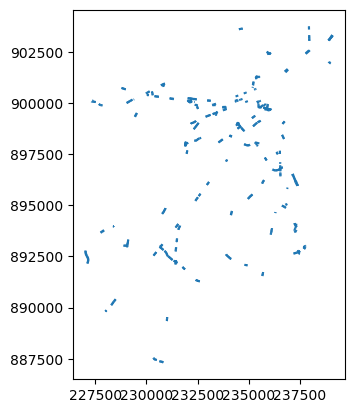

In [122]:
suitable_roads.clip(secured_areas,keep_geom_type=False).plot()

<Axes: >

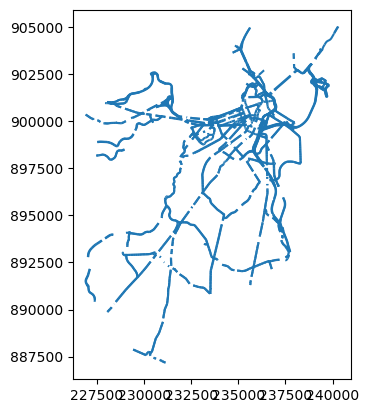

In [123]:
suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').plot()

<Axes: >

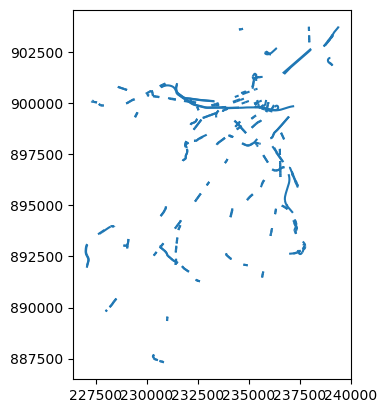

In [124]:
suitable_roads.sjoin(secured_areas, predicate='intersects').plot()

Why **clip** is a poor choice?
- Keeps only the parts that overlap with the mask. We want the opposite - to remove the overlapping parts (this would give you only roads inside school zones (the exact opposite!))

Why **sjoin** is a poor choice?
- You do get the precise locations that should not be included, you get the whole row element (more area). Since sjoin does not have a **not-intersects** predicate, this will also be wrong:

```
bad_geoms = suitable_roads.clip(secured_areas)
good_segments = suitable_roads.overlay(bad_geoms, how='difference')
```

Then:

In [125]:
good_routes_forGas_dissolved=suitable_roads.overlay(secured_areas,keep_geom_type=False, how='difference').dissolve()
good_routes_forGas=gpd.GeoDataFrame(geometry=good_routes_forGas_dissolved.geometry)
good_routes_forGas

,geometry
0,"MULTILINESTRING ((236538.63 896605.726, 236537..."


<Axes: >

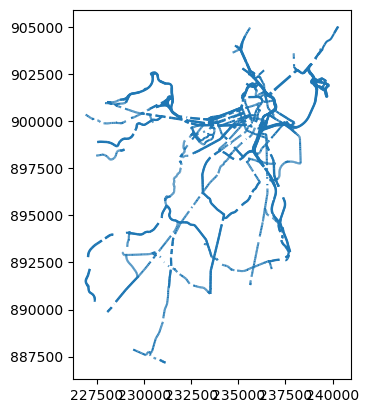

In [126]:
good_routes_forGas.plot()

We may choose a location from those places:

In [127]:
# newCOMPETITORS=safe_fuelCompetitors_gdf.copy()
potential_Locations=good_routes_forGas.copy()
newPOLYGONS=[]
pointsComputed=1
attempts=1
while pointsComputed<=len(gas_relocate):
  candidatePoint=potential_Locations.sample_points(1)
  candidateStation=gpd.GeoDataFrame(geometry=candidatePoint.buffer(100))
  if candidateStation.overlay(secured_areas,how='intersection',keep_geom_type=False).empty:
    newPOLYGONS.append(candidateStation)
    pointsComputed+=1
    potential_Locations=potential_Locations.overlay(candidateStation, how='difference', keep_geom_type=False)
  if attempts>len(gas_relocate)*10:
    break
  attempts+=1

# some info
attempts,len(newPOLYGONS)



(9, 7)

In [128]:
newPOLYGONS

[                                            geometry
 0  POLYGON ((236283.928 901855.092, 236283.446 90...,
                                             geometry
 0  POLYGON ((237257.611 900421.134, 237257.13 900...,
                                             geometry
 0  POLYGON ((229159.633 901059.737, 229159.151 90...,
                                             geometry
 0  POLYGON ((236904.885 901271.117, 236904.404 90...,
                                             geometry
 0  POLYGON ((237635.923 900179.82, 237635.441 900...,
                                             geometry
 0  POLYGON ((233199.04 896789.224, 233198.559 896...,
                                             geometry
 0  POLYGON ((235535.119 901641.123, 235534.637 90...]

In [129]:
pd.concat(newPOLYGONS)

,geometry
0,"POLYGON ((236283.928 901855.092, 236283.446 90..."
0,"POLYGON ((237257.611 900421.134, 237257.13 900..."
0,"POLYGON ((229159.633 901059.737, 229159.151 90..."
0,"POLYGON ((236904.885 901271.117, 236904.404 90..."
0,"POLYGON ((237635.923 900179.82, 237635.441 900..."
0,"POLYGON ((233199.04 896789.224, 233198.559 896..."
0,"POLYGON ((235535.119 901641.123, 235534.637 90..."


In [130]:
GoodLocationsGas_buffered_gdf=pd.concat(newPOLYGONS)
GoodLocationsGas_gdf=gpd.GeoDataFrame(geometry=GoodLocationsGas_buffered_gdf.centroid)

<Axes: >

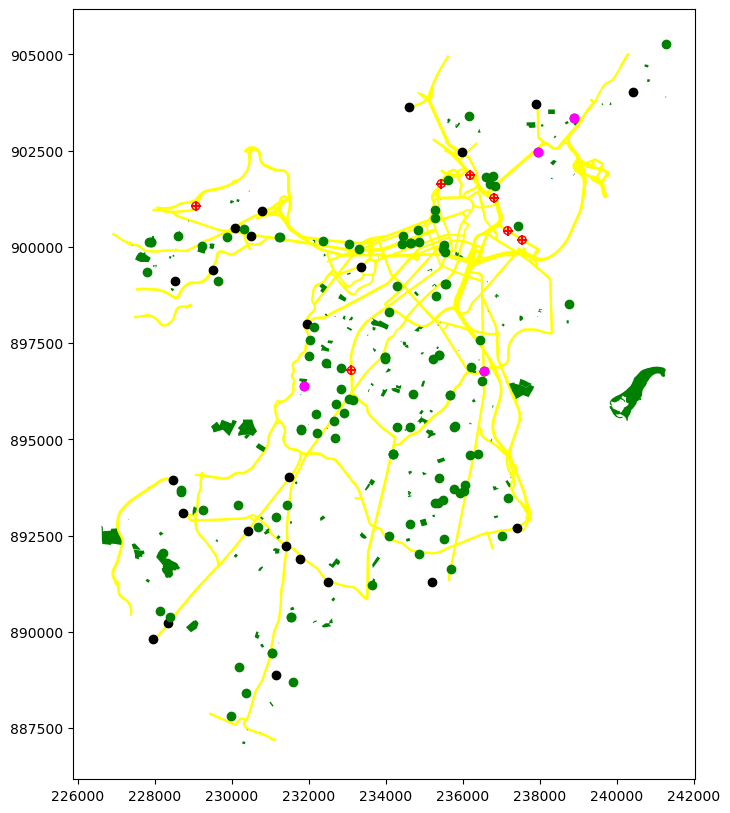

In [131]:
# original suitable roads
base = suitable_roads.plot(color='yellow', figsize=(10, 10),zorder=1)

# non-overlapping buffers
GoodLocationsGas_buffered_gdf.plot(ax=base, edgecolor='red', marker="+", facecolor='none',zorder=2)

# center points of the buffers
GoodLocationsGas_gdf.plot(ax=base, color='red', marker="+", markersize=50,zorder=3)

# all stations
fuelBoston.plot(ax=base,color='k',zorder=4)
schoolBoston.plot(ax=base,color='green',zorder=5)

# stations to relocate
fuelBoston.clip(gas_relocate).plot(ax=base,color='magenta',zorder=5)


## Reverse geocoding

Just get some addresses:

In [132]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="boston_gas_stations")

def get_address(point):
  # Now coordinates are in degrees (lon, lat)
  lon = point.x
  lat = point.y
  location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
  time.sleep(1)  # Rate limiting

  if location:
    return location.address
  else:
    return None # not found

In [133]:
# Get addresses
GoodLocationsGas_4326 = GoodLocationsGas_gdf.to_crs('EPSG:4326')
GoodLocationsGas_gdf['address'] = GoodLocationsGas_4326.geometry.apply(get_address)

In [134]:
GoodLocationsGas_gdf

,geometry,address
0,POINT (236183.928 901855.092),"John F. Fitzgerald Expressway, West End, Bosto..."
0,POINT (237157.611 900421.134),"Evelyn F. Moakley Bridge, Seaport Boulevard, S..."
0,POINT (229059.633 901059.737),"Leo M. Birmingham Parkway, Brighton, Boston, S..."
0,POINT (236804.885 901271.117),"Cross Street, Waterfront, North End, Boston, S..."
0,POINT (237535.923 900179.82),"121 Seaport, 113;121;129, Seaport Boulevard, S..."
0,POINT (233099.04 896789.224),"Columbus Avenue, Roxbury, Boston, Suffolk Coun..."
0,POINT (235435.119 901641.123),"Storrow Drive, West End, Boston, Suffolk Count..."


______

[BACK TO MAIN MENU](https://dacss-spatial.github.io/GDF_OPS_applications/)